# Исследование оттока клиентов

**Описание исследования**

Заказчик -  сеть фитнес-центров «Культурист-датасаентист».

**Цель исследования** - разработать стратегию взаимодействия с клиентами: сделать прогноз вероятности оттока клиентов, сформировать типичные портреты клиентов, проанализировать полученную информацию, дать рекомендации. 

**Описание данных**

Входные данные - csv-файл, который содержит данные на месяц до оттока и факт оттока на определённый месяц.

Таблица gym_churn.csv содержит следующие поля:
1. gender — пол;
2. Near_Location — проживание или работа в районе, где находится фитнес-центр;
3. Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
4. Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
5. Phone — наличие контактного телефона;
6. Age — возраст;
7. Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
8. Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
9. Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
10. Group_visits — факт посещения групповых занятий;
11. Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
12. Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
13. Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
14. Churn — факт оттока в текущем месяце.


**Ход исследования**
 
Перед тем, как разработать стратегию взаимодействия с клиентами, необходимо провести обзор данных, их предобработку, разведочный анализ данных, построение модели прогнозирования и кластеризацию клиентов.
 
Таким образом, исследование пройдёт в шесть этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Разведочный анализ данных (EDA).
 4. Построение модели прогнозирования.
 5. Кластеризация клиентов.
 6. Общий вывод

## Обзор данных

In [3]:
# Импортируем необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [4]:
# Откроем датасет
data = pd.read_csv('/datasets/gym_churn.csv')

In [5]:
# Получим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
# Проверим датасет на наличие дубликатов
data.duplicated().sum()

0

**Вывод:**

- Всего в таблице: 13 столбцов и 4000 строк
- Пропуски в таблице не найдены
- Дубликаты в таблице не найдены
- В столбце Month_to_end_contract можно изменить тип данных с float на int
- Названия столбцов необходимо привести к одному виду

## Предобработка данных

In [7]:
# Изменим тип данных в столбце Month_to_end_contract с float на int
data['Month_to_end_contract'] = data['Month_to_end_contract'].astype('int')

In [8]:
# Приведем названия столбцов к одному виду
data.columns = data.columns.str.lower()

In [9]:
# Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Вывод:**

- В столбце month_to_end_contract тип данных был изменен на int
- Все названия столбцов таблицы были приведены к одному виду

## Разведочный анализ данных (EDA)

In [10]:
# Посмотрим описательные статистики для столбцов с числовыми данными
data[['contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']].describe()

,contract_period,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,552.590740,12.000000,31.000000,6.023668,6.146783


In [11]:
# Посмотрим средние значения для всех признаков в разрезе на тех, кто ушел в отток и кто остался
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


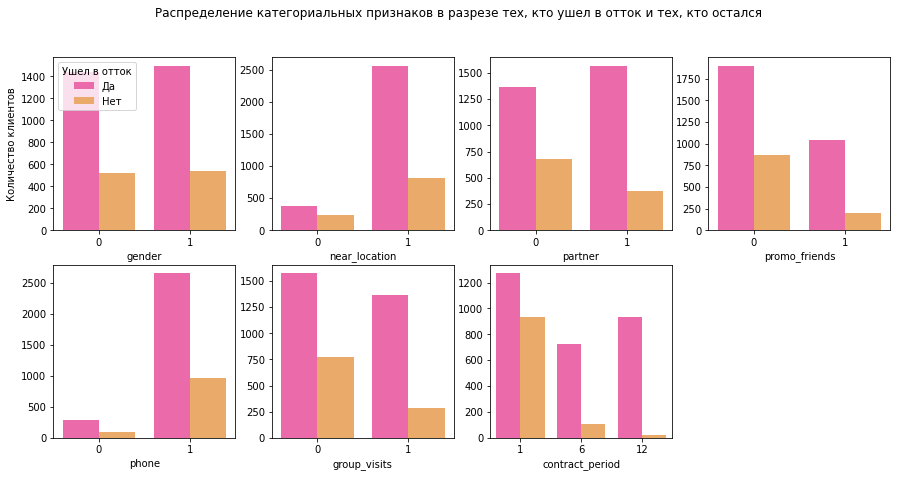

In [12]:
# Напишем код для визуализации категориальных признаков в разрезе тех, кто ушел в отток, и остался
signs = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Распределение категориальных признаков в разрезе тех, кто ушел в отток и тех, кто остался')

for i, col in enumerate(signs):
    plt.subplot(2, 4, i + 1)
    sns.countplot(data=data, x=col, hue='churn', palette='spring')
    if i == 0:
        plt.ylabel('Количество клиентов')
        plt.legend(title='Ушел в отток', loc='upper left', labels=['Да', 'Нет'])
    else:
        plt.ylabel(None)
        plt.legend([],[], frameon=False)

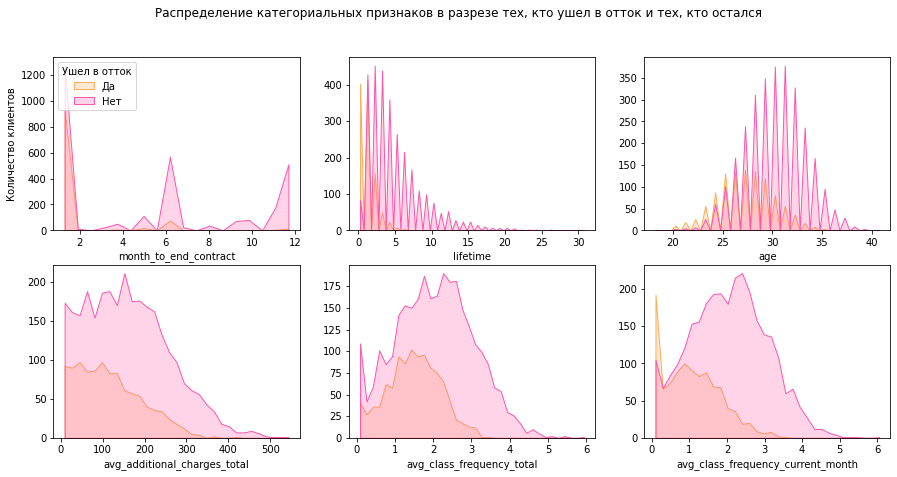

In [13]:
# Напишем код для визуализации числовых признаков в разрезе тех, кто ушел в отток, и остался
num_signs = ['month_to_end_contract', 'lifetime', 'age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
fig1 = plt.figure(figsize=(15, 7))
fig1.suptitle('Распределение категориальных признаков в разрезе тех, кто ушел в отток и тех, кто остался')

for i, col in enumerate(num_signs):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=data, x=col, hue='churn', element='poly', palette='spring')
    if i == 0:
        plt.ylabel('Количество клиентов')
        plt.legend(title='Ушел в отток', loc='upper left', labels=['Да', 'Нет'])
    else:
        plt.ylabel(None)
        plt.legend([],[], frameon=False)

In [14]:
# Построим матрицу корреляций для всех признаков
data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


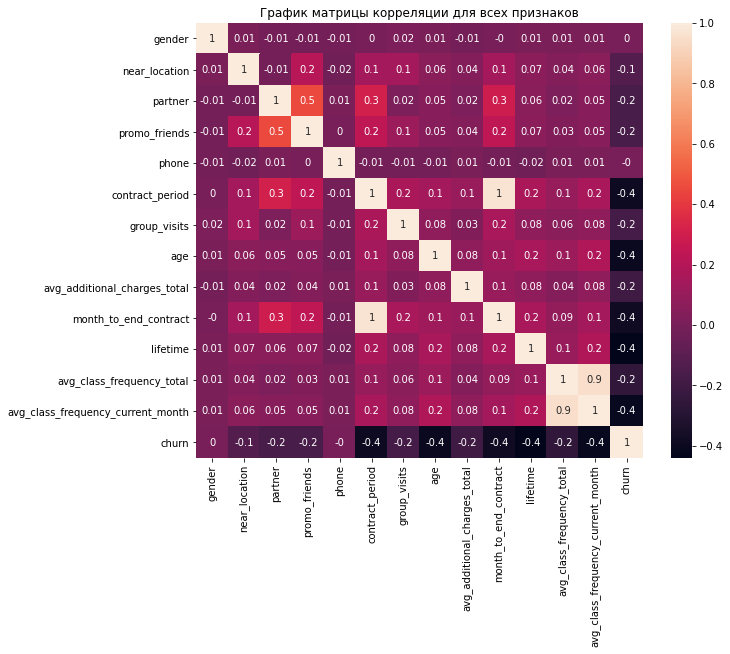

In [15]:
# Визуализируем корреляционную матрицу
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr().round(decimals=2), annot = True, fmt='.1g')
plt.title('График матрицы корреляции для всех признаков')
plt.show()

**Вывод:**
- Исходя из описательных статистик мы можем сказать, что числовые данные неоднородны, практически для всех признаков стандартное отклонение почти равно среднему, это стоит учесть при выборе метрик ML
- Судя по среднему среди категориальных признаков и графикам, для тех, кто ушел в отток, более характерно: дальнее расстояние от фитнес-центра, отсутствие работодателя - партнера клуба (т.е. отсутствие скидки), отсутствие промо-кода от друга, относительно небольшой интерес к групповым занятиям, контракт с фитнес-центром на месяц. Судя по среднему числовых признаков и графикам, для ушедших более характерно: меньший период до конца контракта, меньший период с первого посещения, более молодая аудитория, меньшие доп. траты, меньшая частота посещений за прошедщий месяц и в целом.
- Судя по матрице корреляций, отток имеет наиболее высокую обратную зависимость (-0,4) с такими признаками, как контрактный период, возраст, количество месяцев до конца контракта, время с момента первого обращения в фитнес-центр и средняя частота посещений в неделю за предыдущий месяц. Между признаками период контракта и период до окончания контракта коэф. корреляции равен 1, они зависят друг от друга, это может повлиять на качество ML модели.

## Построение модели прогнозирования оттока клиентов

In [16]:
# Для прогнозирования на основе этих данных больше всего подайдут модели бинарной регрессии: логистическая регрессия, и классификатор случайный лес

In [17]:
# Разделим датасет на признаки (X) и целевую переменную (y)
X = data.drop('churn', axis = 1)
y = data['churn']

In [18]:
# Разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# Создади модель стандартизации и обучим ее
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [20]:
# Преобразуем обучающую и валидационную выборку 
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [27]:
# Напишем функцию для автоматизации получения прогнозов для разных моделей
def get_predictions(model, x_train, y_train, x_test):
    model_name = model # Создадим модель
    model_name.fit(x_train, y_train) # Обучим модель на обучающей выборке
    return model_name.predict(x_test) # Сделаем прогнозы на валидационной выборки

In [28]:
# Получим прогнозы для модели логической регресиии
lr_predictions = get_predictions(LogisticRegression(), X_train_st, y_train, X_test_st)

In [29]:
# Получим прогнозы для модели случайного леса
rf_predictions = get_predictions(RandomForestClassifier(random_state = 0), X_train, y_train, X_test)

In [30]:
# Напишем функцию для подсчета метрик
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [31]:
# Подсчитаем метрики для модели логической регрессии
print_all_metrics(y_test, lr_predictions, 'Метрики классификации для модели логической регрессии')

Метрики классификации для модели логической регрессии
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [32]:
# Подсчитаем метрики для модели случайного леса
print_all_metrics(y_test, rf_predictions, 'Метрики классификации для случайного леса')

Метрики классификации для случайного леса
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


**Вывод:**
- Судя по метрикам, модели показали одинаковую точность относительно всех классов, однако модель логической регрессии показала бОльшую точность относительно класссов по отдельности.
- Следовательно, модель логистической регрессии показала себя лучше

## Кластеризация клиентов

In [37]:
# Стандартизируем признаки (X)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [38]:
# Создадим связку стандартизированных признаков, чтобы диаграмма получилась показательной, передадим параметру method значение 'ward'
linked = linkage(X_sc, method = 'ward')

In [ ]:
# Визуализируем связки в виде дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-центра')
plt.show()

Судя по дендрограмме, наиболее четко выделяются 4 кластера, однако, если внимательнее посмотреть, то можно увидеть в самом большом кластере еще 3, итого: 6

In [39]:
# Пошагово сгруппируем объекты методом KMeans, в атрибуте укажем предполагаемое количество кластеров = 5 и зафиксируем случайное состояние алгоритма с помощью random_state
km = KMeans(n_clusters=5, random_state=0) 

In [40]:
# Сохраним индексы предложенных алгоритмом групп 
labels = km.fit_predict(X_sc)

In [41]:
# Добавим метки кластера в поле датасета
data['clusters'] = labels

In [71]:
# Выведем статистику по средним значениям признаков по кластеру
data.groupby('clusters').mean().sort_values(by='churn', ascending=False)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
clusters,,,,,,,,,,,,,,
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723


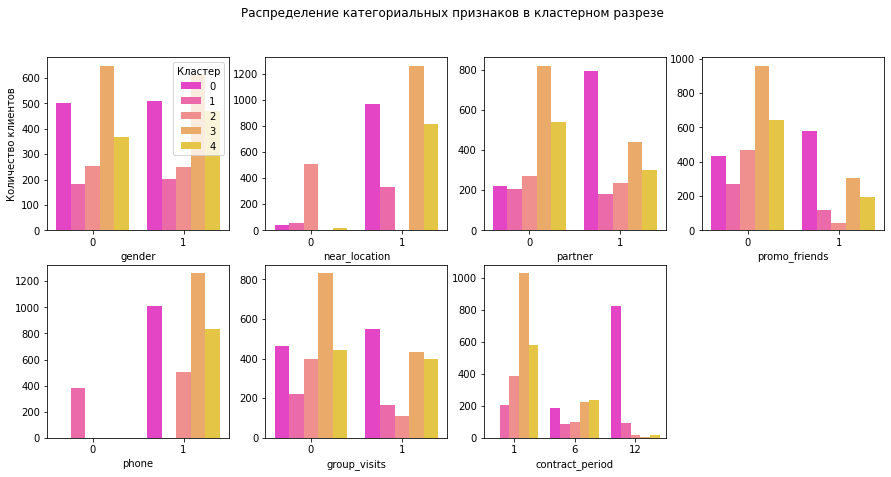

In [42]:
# Построим графики распределения по кластерам для категориальных признаков
fig2 = plt.figure(figsize=(15, 7))
fig2.suptitle('Распределение категориальных признаков в кластерном разрезе')

for i, sign in enumerate(signs):
    plt.subplot(2, 4, i + 1)
    sns.countplot(data=data, x=sign, hue='clusters', palette='spring')
    if i == 0:
        plt.ylabel('Количество клиентов')
        plt.legend(title='Кластер')
    else:
        plt.ylabel(None)
        plt.legend([],[], frameon=False)

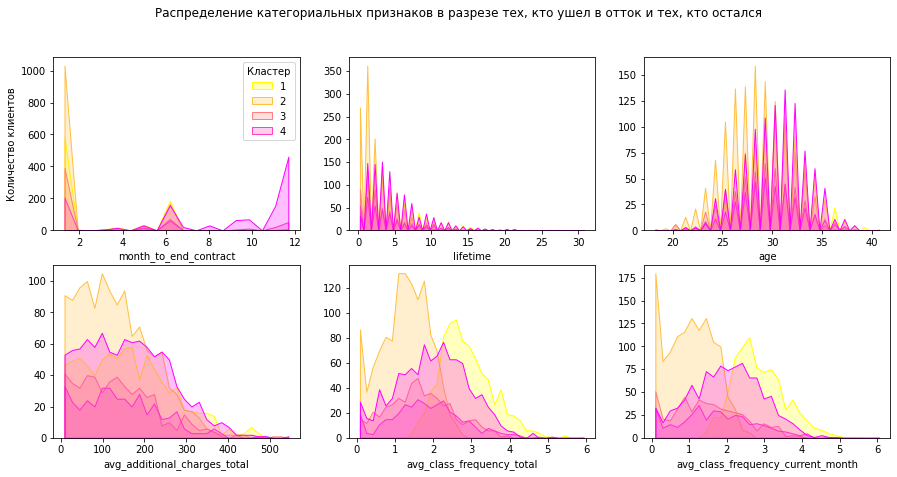

In [47]:
# Напишем код для визуализации числовых признаков в кластерном разрезе
fig3 = plt.figure(figsize=(15, 7))
fig3.suptitle('Распределение категориальных признаков в разрезе тех, кто ушел в отток и тех, кто остался')

for i, col in enumerate(num_signs):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=data, x=col, hue='clusters', element='poly', palette='spring')
    if i == 0:
        plt.ylabel('Количество клиентов')
        plt.legend(title='Кластер', labels=[1, 2, 3, 4])
    else:
        plt.ylabel(None)
        plt.legend([],[], frameon=False)

**Вывод:**
- Самая высокая доля оттока у кластера 3 (0,51), самая низкая у кластера 0 (0,02) и 4 (0,06). Также различие этих кластеров заключается в том, что для кластера 0 значительно выше доля признаков работодатель-партнер и промо-код от друга.
- Судя по таблице средних выделяется кластер 2 по наименьшему количеству человек, для которых расположение фитнес-центра удобно (0,0), кластер 1 выделяется по наименьшему количеству человек, указавших телефон (0,0). Для этих кластеров также характерна относительно высокая доля оттока клиентов (0,26 и 0,44 соответственно). Кластер 0 выделяется наибольшей длительностью контрактного периода и соответственно длительностью окончания этого периода. Для этого кластера характерна самая низкая доля оттока.
- Судя по графикам, на пиковых значениях числовых признаков, как лайфтайм, период до окончания контракта, доп. траты, средняя частота посещений в целом и в месяц, по количеству лидируют кластеры 4 и 0.
- Также по графикам видно, что в целом, самый многочисленный кластер - 3, с самой высокой доля оттока.

## Общий вывод

Таким образом, исследование было выполнено в шесть этапов:

 1. Обзор данных.
 2. Предобработка данных.
 3. Разведочный анализ данных (EDA).
 4. Построение модели прогнозирования.
 5. Кластеризация клиентов.
 6. Общий вывод
 
**Разведочный анализ данных: выводы**
- Судя по среднему среди категориальных признаков, для тех, кто ушел в отток, более характерно: дальнее расстояние от фитнес-центра, отсутствие работодателя - партнера клуба (т.е. отсутствие скидки), отсутствие промо-кода от друга, относительно небольшой интерес к групповым занятиям, контракт с фитнес-центром на месяц. 
- Судя по среднему числовых признаков и графикам, для ушедших более характерно: меньший период до конца контракта, меньший период с первого посещения, более молодая аудитория, меньшие доп. траты, меньшая частота посещений за прошедщий месяц и в целом.
- Судя по матрице корреляций, отток имеет наиболее высокую обратную зависимость (-0,4) с такими признаками, как контрактный период, возраст, количество месяцев до конца контракта, время с момента первого обращения в фитнес-центр (лайфтайм) и средняя частота посещений в неделю за предыдущий месяц.

**Кластеризация клиентов: выводы**
- Самая высокая доля оттока у кластера 3 (0,51), самая низкая у кластера 0 (0,02) и 4 (0,06). 
- Для кластера 3 характерен меньший контрактный период (1,9 мес.) и соответственно меньший период до окончания контракта (1,85), меньшие средние доп. траты (131), меньший лайфтайм (2,44 мес.), меньшая частота посещения в целом и в текущий месяц (1,24 и 1,01 соответственно).
- Для кластера 4 наоборот характерны самые высокие доли по этим показателям, за исключением признаков период контракта и период до окончания контракта, которые выше всего у кластера 0. Также различие этих кластеров заключается в том, что для кластера 0 значительно выше доля признаков работодатель-партнер и промо-код от друга.

**Общий вывод:**
- Наиболее влияющими на отток можно считать признаки: контрактный период, период до окончания контракта и средняя частота посещений в неделю за предыдущий месяц. Также значимыми, но менее влияющими признаками могут быть неудобное расположение (дальнее расстояние), отсутствие работодателя партнера-клуба, отсутствие промо-кода от друга.
- Как рекомендация, можно обратить внимание на клиентов, которые совершают больше доп. трат, наиболее часто ходят на занятия, однако не имеют скидки от работодателя-партнера и промо-кода от друга (как клиенты из кластера 4), предложить им специальное предложение, как поощрение. Также, вероятность оттока более высока у клиентов с небольшой длительностью контракта, их необходимо удержать, настроить рассылку или прозвон по окончанию контракта с целью продлить абонемент. 